# Artificial neural network for Water Distribution Systems Metamodelling - Machine learning project (2/2)

**Objectives:**
- Implement a genetic algorithm that uses a metamodel to find an appropriate solution for the optimization of a water distribution system.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Defining the optimization problem
  - Solving the optimization problem using the metamodel developed previously
  - Analyzing the optimization problem
- Answered all the questions

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Pandas
- Numpy
- Matplotlib
- WNTR
- Scikit-learn
- PyMOO

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import wntr

# Genetic algorithm dependencies
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import IntegerRandomSampling

# Artificial neural network dependencies
from sklearn.neural_network import MLPRegressor

## ⛔ Problem definition 

The problem is to find the pipe diameters that minimize the cost of the pipe lines while satisfying the customer demand for water usage and supply pressure. 

<!-- For this application, we will only consider systems feed by reservoirs that work via gravity. -->

### 🎯 Objective function

We want to minimize the cost of the pipes. Each pipe has a different cost according to its diameter and its length. Generally, the larger the pipe, the more expensive it is. 

We can define the total cost $Z$ of installing all the pipes as the following function
$$
\begin{align}
  & min Z = \sum_{j=1}^{N}C_{j}\sum_{i=1}^{M} L_{ij}\\
\end{align}
$$ (eq_cost_function)

where $C_{j}$ is the cost of pipe per meter-length having diameter $j$.

### 🚫 Restrictions

We consider one main restriction.

1) The water should arrive at the consumer nodes with sufficient pressure. This is, there should be sufficient energy for transporting the water from the source to each of nodes. This restriction can be written as

$$
\sum_{i=1}^{N} H_{i} \leq H^{*} 
$$

<!-- \; \text{for every node i in the system.} -->

## 🧬+🤖 Exercise: Genetic algorithm with ANN metamodel

### 1. Load the metamodel

In [5]:
with open('model_Sklearn.p', 'rb') as handle:
    metamodel = pickle.load(handle)

In [6]:
max_target = 41.40673065185547 #Value to unnormalize the values

Trying the metamodel

In [9]:
# Giving a random input of 317 pipes...
random_input = np.random.rand(1,317)
# The metamodel returns a prediction of 272 nodal pressures
print(metamodel.predict(random_input).shape)

(1, 272)


### 2. Define optimization problem

In [10]:
MM_TO_M = 0.001
cost_function_diameter_mm = {
    100: 27.7,
    125: 38.0,
    150: 40.5,
    200: 55.4,
    250: 75.0,
    300: 92.4,
    350: 123.1,
    400: 141.9,
    450: 169.3,
    500: 191.5,
    600: 246.0,
    700: 319.6,
    800: 391.1
}

pipe_index = {
    0:100,
    1:125,
    2:150,
    3:200,
    4:250,
    5:300,
    6:350,
    7:400,
    8:450,
    9:500,
    10:600,
    11:700,
    12:800,
    }

H_star = 20

def transform_index_to_diameter(matrix_indexes, pipe_index):
    return np.array([[pipe_index[j] for j in vector_indexes] for vector_indexes in matrix_indexes])

def transform_diameter_to_cost(matrix_diameters, cost_function_diameter_mm):
    return np.array([[cost_function_diameter_mm[j] for j in vector_indexes] for vector_indexes in matrix_diameters])

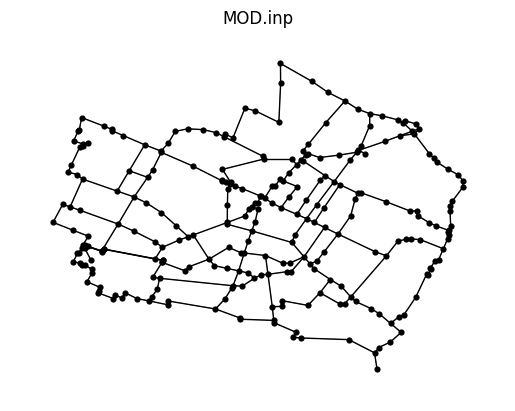

<Axes: title={'center': 'MOD.inp'}>

In [11]:
# Create a water network model
inp_file = 'MOD.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)

In [12]:
node_elevation = wn.query_node_attribute('elevation')
pipe_lengths = wn.query_link_attribute('length')


In [13]:
class ModenaOptimization(Problem):
    
    def __init__(self):
        super().__init__(n_var=317, n_obj=1, n_ieq_constr=268, xl=0.0, xu=12.0, vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        global pressure_heads
        new_population = transform_index_to_diameter(x, pipe_index)
        cost_per_unit_length = transform_diameter_to_cost(new_population, cost_function_diameter_mm)
        
        costs = cost_per_unit_length @ pipe_lengths
        
        # new_population_tensor = torch.tensor(new_population, dtype = torch.float32)
        pressure_tensor = metamodel.predict(new_population*MM_TO_M)[:, :-4]
        pressure_heads = max_target * pressure_tensor + node_elevation.values
        
        out["F"] = costs
        out["G"] = -(pressure_heads - H_star)

problem = ModenaOptimization()

method = GA(pop_size=20,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True,
            )

res = minimize(problem,
               method,
               termination=('n_gen', 1000),
               seed=1,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  0.000000E+00 |  0.000000E+00 |  1.009557E+07 |  9.148062E+06
     2 |       40 |  0.000000E+00 |  0.000000E+00 |  9.169780E+06 |  7.622350E+06
     3 |       60 |  0.000000E+00 |  0.000000E+00 |  8.177076E+06 |  6.439084E+06
     4 |       80 |  0.000000E+00 |  0.000000E+00 |  7.067639E+06 |  6.295733E+06
     5 |      100 |  0.000000E+00 |  0.000000E+00 |  6.454190E+06 |  5.630856E+06
     6 |      120 |  0.000000E+00 |  0.000000E+00 |  5.984752E+06 |  4.839170E+06
     7 |      140 |  0.000000E+00 |  0.000000E+00 |  5.464630E+06 |  4.607754E+06
     8 |      160 |  0.000000E+00 |  0.000000E+00 |  5.097123E+06 |  4.484092E+06
     9 |      180 |  0.000000E+00 |  0.000000E+00 |  4.727093E+06 |  4.392559E+06
    10 |      200 |  0.000000E+00 |  0.000000E+00 |  4.532260E+06 |  4.307498E+06
    11 |      220 |  0.000000E+00 |  0.000000E+00 |  4.391818E+06 |  4.235877E+06
    12 |      24

In [14]:
best_solution = np.array([100]*317).reshape((1,-1))
pressure_tensor = metamodel.predict(best_solution*MM_TO_M)[:, :-4]
pressure_heads = max_target * pressure_tensor + node_elevation.values

### 3. Assess the results

In [15]:
optimal_diameters = transform_index_to_diameter([res.X], pipe_index)[0]*MM_TO_M
print(optimal_diameters)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 

In [16]:
# Modify the water network
for j, pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    # Modify the water network 
    pipe.diameter = optimal_diameters[j]
    
#Simulate the individual
wn.options.hydraulic.demand_model = 'PDD'
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

c:\Users\agarzondiaz\surfdrive\Year_3\Educational activities\MUDE\Optimization\venv_MUDE_Opt\lib\site-packages\wntr\epanet\io.py:1727: UserWarning: REQUIRED PRESSURE is below the lower limit for EPANET (0.1 in psi or m). The value has been set to 0.1 in the INP file.
  warnings.warn('REQUIRED PRESSURE is below the lower limit for EPANET (0.1 in psi or m). The value has been set to 0.1 in the INP file.')


Pressure heads given by the numerical model

In [17]:
results.node['head'].values#.min().min()

array([[39.918, 39.289, 38.388, 37.25 , 36.666, 35.969, 35.97 , 36.825, 36.837, 37.529, 42.368, 39.91 , 39.5  , 39.862, 39.757, 39.735, 39.718, 52.375, 71.886, 57.754, 48.944, 43.085, 39.207, 35.111, 34.243, 33.542, 33.472, 35.321, 34.686, 34.611, 34.52 , 34.195, 33.489, 33.48 , 33.566, 32.454,
        32.105, 31.914, 31.817, 31.664, 32.662, 32.726, 33.98 , 35.065, 37.603, 43.03 , 34.062, 34.068, 40.608, 53.081, 64.365, 71.316, 37.29 , 36.945, 36.525, 36.324, 36.158, 35.823, 34.849, 35.504, 35.148, 35.134, 37.168, 37.003, 36.947, 36.969, 36.987, 36.997, 37.239, 37.507, 37.649, 37.801,
        37.896, 38.221, 38.27 , 38.657, 39.208, 36.775, 36.171, 35.793, 35.831, 35.992, 35.503, 35.504, 35.343, 34.977, 35.14 , 34.847, 34.805, 34.746, 34.593, 34.866, 34.85 , 35.681, 36.171, 36.254, 36.985, 37.557, 35.549, 34.63 , 34.245, 33.734, 33.662, 33.595, 33.522, 34.358, 34.477, 34.566,
        35.451, 34.634, 32.69 , 34.491, 34.05 , 34.493, 32.966, 40.   , 39.802, 39.909, 40.003, 41.393, 36.308, 

Pressure heads given by the metamodel

In [18]:
print(pressure_heads[0])

[69.445 69.289 69.147 69.062 69.005 68.804 68.819 69.136 69.145 69.359 70.408 69.637 69.495 69.591 69.437 69.395 69.402 72.144 73.497 72.308 71.573 70.613 69.802 68.61  68.455 68.379 68.373 68.566 68.368 68.328 68.315 68.378 68.504 68.716 68.882 68.29  68.394 68.608 68.662 68.971 69.545 69.457
 69.447 69.46  69.726 70.237 69.087 69.107 70.433 71.017 71.698 71.99  68.638 68.868 68.662 68.506 68.442 68.322 68.241 68.222 68.18  68.18  68.441 68.299 68.21  68.145 68.094 68.075 68.078 68.069 68.08  68.091 68.114 68.245 68.252 68.357 68.78  68.062 68.174 68.133 68.137 68.149 68.147 68.142
 68.205 68.212 68.198 68.242 68.427 68.524 68.76  68.313 68.295 68.334 68.524 68.711 69.572 70.297 68.296 68.241 68.365 68.536 68.532 68.539 68.565 68.707 69.225 69.376 69.719 69.303 68.677 68.451 68.362 68.3   68.535 70.16  70.134 70.128 70.147 70.268 69.344 68.178 67.523 67.728 67.77  68.177
 68.    67.839 67.809 68.35  68.925 68.309 68.317 68.407 70.39  73.419 71.225 68.65  68.418 69.335 69.353 69.173 68

In [19]:
results.node['pressure']

name,1,2,3,4,5,6,7,8,9,10,...,263,264,265,266,267,268,269,270,271,272
0,0.42794,-0.330803,-0.312218,0.000159,0.395683,0.019281,0.020156,0.735415,0.6569,0.529158,...,-2.049179,18.892904,-1.472863,-1.125653,-0.788948,-0.899793,5.493164e-07,0.000002,-2.441406e-08,0.000001
